# Домашнее задание 2. Кластеризация векторного пространства

<ol>
  <li>Взять любую предобученную векторную модель для русского языка и извлечь оттуда вектор для глагола и каждого существительного из списка. Здесь лежит хендаут по word2vec, который может вам пригодиться.</li>
  <li>На основе этих векторов построить репрезентацию для каждой пары «глагол + существительное» с помощью простой аддитивной модели композиции.</li>
</ol>

In [1]:
from gensim.models import KeyedVectors


model = KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [86]:
with open("HW2_igrat'.txt", "r", encoding='utf-8') as file:
    pairs = file.read().splitlines()

In [87]:
vector_representations = []
collocations = []
for pair in pairs:
    collocation, count = pair.split()
    count = int(count)
    verb, noun = collocation.split("_")
    verb = verb + "_VERB"
    noun = noun + "_NOUN"
    if verb in model and noun in model:
        collocations.append(collocation)
        verb_vector = model[verb]
        noun_vector = model[noun]
        compose_vector = verb_vector + noun_vector
        vector_representations.append(compose_vector)

In [88]:
import numpy as np

vectors_matrix = np.array(vector_representations)
print (vectors_matrix.shape)

(113, 300)


Собрать все векторные представления пар в единую матрицу и кластеризовать их двумя способами:
методом иерархической кластеризации;
методом К-средних, см. хендаут.

В первом случае количество кластеров определяется автоматически (но задается значение порога t), во втором случае количество кластеров нужно задать вручную. Возьмите то значение каждого из этих параметров, которое вам кажется наиболее удачным и обоснуйте свое решение (одного-двух предложений будет вполне достаточно). Все остальные параметры в обоих случаях можно не менять и использовать настройки по умолчанию.

## Иерархическая кластеризация

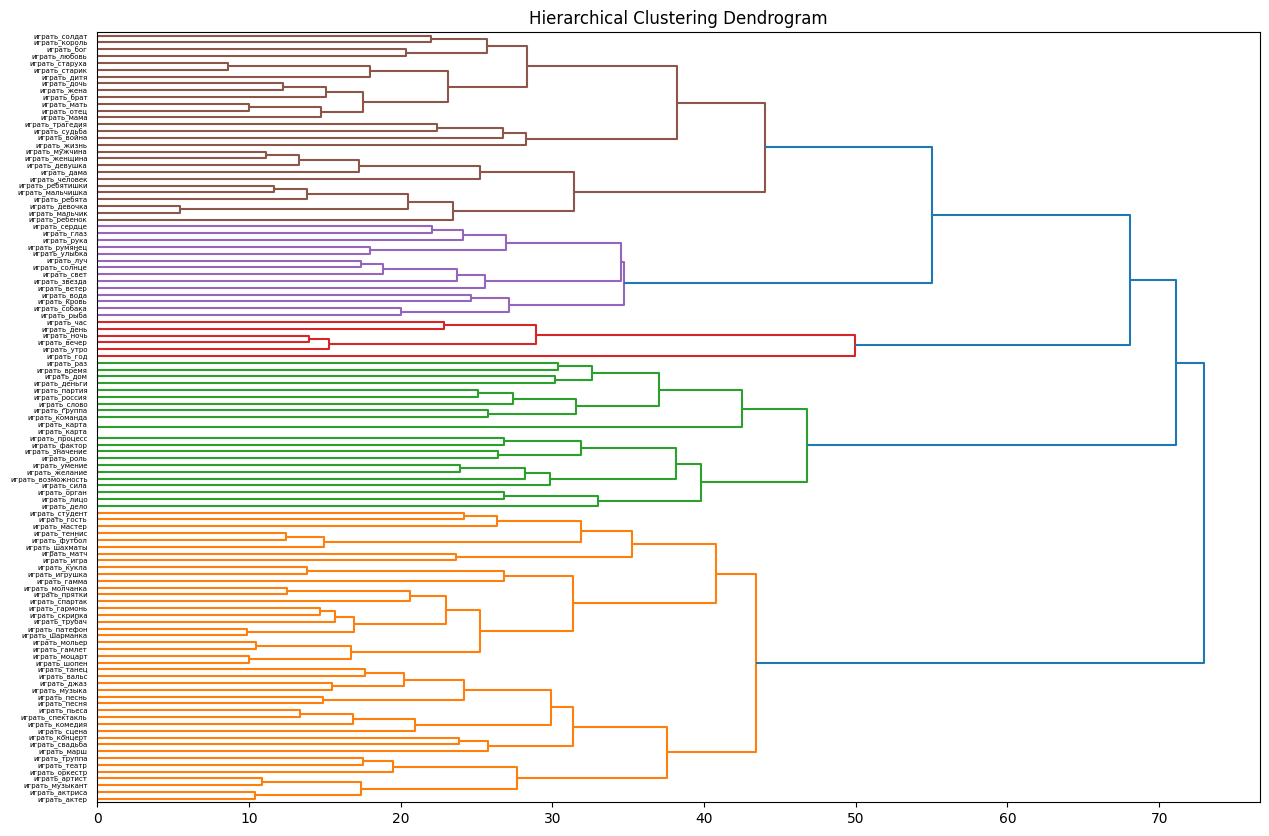

In [89]:
from scipy.cluster.hierarchy import ward, dendrogram
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as hcluster

linkage_matrix = ward(vectors_matrix)

plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, orientation="right", labels=collocations)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


In [90]:
clusters = hcluster.fcluster(linkage_matrix, 1)
print('Estimated number of clusters: %d' % len(set(clusters)))

Estimated number of clusters: 34


Для каждого кластера определите центр и выберите по три элемента, наиболее к нему близких (по метрике косинусной близости). Центр можно определить как среднее арифметическое среди всех элементов кластера по каждому измерению (например, с помощью метода numpy.mean). Кластеры, размер которых не превышает двух элементов, не учитывайте совсем.


Оформите результат в виде набора групп из трех словосочетаний, например:
идти_дождь, идти_снег, идти_град
идти_часы, идти_время, идти_урок
…

In [92]:
# Автоматическая кластеризация
from sklearn.metrics.pairwise import cosine_similarity
centers = {}
closest_elements = {}
for label in set(clusters):
    cluster_indices = np.where(clusters == label)[0]
    if len(cluster_indices) <= 2:
        continue
    
    cluster_vectors = [vector_representations[idx] for idx in cluster_indices]
    cluster_center = np.mean(cluster_vectors, axis=0)
    centers[label] = cluster_center
    
    similarities = cosine_similarity(cluster_vectors, [cluster_center])
    closest_indices = similarities.argsort(axis=0, kind='stable')[-3:, 0]
    closest_elements[label] = [collocations[idx] for idx in closest_indices for idx in cluster_indices]

In [93]:
# Формирование групп из трех словосочетаний
result_groups = []
for label, center in centers.items():
    closest = closest_elements[label]
    group = [closest[i:i+3] for i in range(0, len(closest), 3)]
    result_groups.extend(group)

for idx, group in enumerate(result_groups, 1):
    print(f"Группа {idx}: {', '.join(group)}")

Группа 1: играть_оркестр, играть_театр, играть_труппа
Группа 2: играть_оркестр, играть_театр, играть_труппа
Группа 3: играть_оркестр, играть_театр, играть_труппа
Группа 4: играть_свадьба, играть_концерт, играть_марш
Группа 5: играть_свадьба, играть_концерт, играть_марш
Группа 6: играть_свадьба, играть_концерт, играть_марш
Группа 7: играть_спектакль, играть_комедия, играть_пьеса
Группа 8: играть_сцена, играть_спектакль, играть_комедия
Группа 9: играть_пьеса, играть_сцена, играть_спектакль
Группа 10: играть_комедия, играть_пьеса, играть_сцена
Группа 11: играть_скрипка, играть_гармонь, играть_прятки
Группа 12: играть_трубач, играть_спартак, играть_шарманка
Группа 13: играть_молчанка, играть_патефон, играть_скрипка
Группа 14: играть_гармонь, играть_прятки, играть_трубач
Группа 15: играть_спартак, играть_шарманка, играть_молчанка
Группа 16: играть_патефон, играть_скрипка, играть_гармонь
Группа 17: играть_прятки, играть_трубач, играть_спартак
Группа 18: играть_шарманка, играть_молчанка, игра

Посмотрим на результаты, получившиеся методом иерархической кластеризацией. Можно заметить, что существительные в словосочетаниях, принадлежащих одной и той же группе, однородны. Например, существительные "ночь", "утро" и "час" относятся к временным отрезкам. Но такое происходит не со всеми кластерами, иногда встречаюстя существительные, относящиеся к теме театра и музыки

## Алгоритм К-средних (KMeans)

используем автоматическое определения количества кластеров с порогом t = 5

In [94]:
import numpy as np
from sklearn.cluster import KMeans


t = 5
kmeans_auto = KMeans(n_clusters=t+1, random_state=0).fit(vectors_matrix)
clusters_auto = kmeans_auto.labels_


print("Результаты автоматической кластеризации:")
for collocation, cluster in zip(collocations, clusters_auto):
    print(f'{collocation}: Cluster {cluster}')

Результаты автоматической кластеризации:
играть_роль: Cluster 5
играть_музыка: Cluster 2
играть_ребенок: Cluster 4
играть_оркестр: Cluster 2
играть_актер: Cluster 2
играть_человек: Cluster 4
играть_время: Cluster 5
играть_карта: Cluster 5
играть_музыкант: Cluster 2
играть_солнце: Cluster 1
играть_дитя: Cluster 4
играть_спектакль: Cluster 2
играть_комедия: Cluster 2
играть_жизнь: Cluster 4
играть_игра: Cluster 5
играть_артист: Cluster 2
играть_мальчик: Cluster 4
играть_свадьба: Cluster 4
играть_женщина: Cluster 4
играть_день: Cluster 3
играть_песня: Cluster 2
играть_девочка: Cluster 4
играть_вечер: Cluster 3
играть_пьеса: Cluster 2
играть_вальс: Cluster 2
играть_команда: Cluster 5
играть_улыбка: Cluster 1
играть_ребята: Cluster 4
играть_актриса: Cluster 2
играть_ветер: Cluster 1
играть_мальчишка: Cluster 4
играть_шахматы: Cluster 4
играть_гамлет: Cluster 4
играть_возможность: Cluster 5
играть_раз: Cluster 5
играть_песнь: Cluster 2
играть_год: Cluster 3
играть_румянец: Cluster 1
играть_р

Можно применить метод "локтя", чтобы выбрать оптимальное число кластеров. Идея заключается в том, что при увеличении числа кластеров улучшение качества кластеризации будет замедляться, и в какой-то момент изменение начнет напоминать сгиб локтя. Такой сгиб обычно указывает на оптимальное число кластеров.

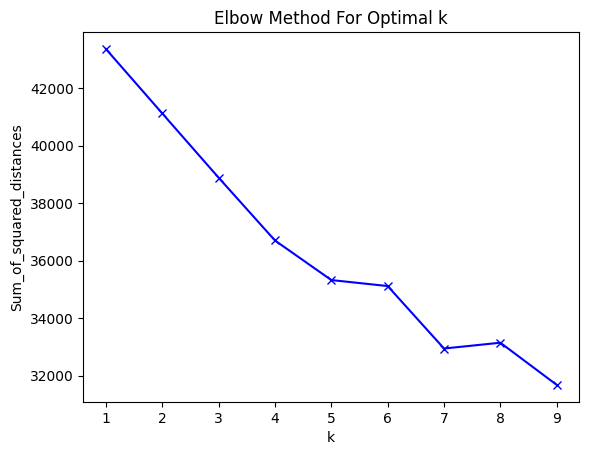

In [96]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Sum_of_squared_distances = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vectors_matrix)
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

При задании количества кластеров вручную, нужно оценить данные и цель кластеризации для выбора числа кластеров, которое позволит выделить смысловые группы в данных. Я выделила 7 групп: некоторые аргументы относятся к теме игр, спортивные игры, театр, музыка, люди и абстрактные понятия, танцы. 

In [97]:
# Ручное задание количества кластеров k = 7
k = 7
kmeans_manual = KMeans(n_clusters=k, random_state=0).fit(vectors_matrix)
clusters_manual = kmeans_manual.labels_

# Результаты ручной кластеризации
print("\nРезультаты ручной кластеризации:")
for collocation, cluster in zip(collocations, clusters_manual):
    print(f'{collocation}: Cluster {cluster}')


Результаты ручной кластеризации:
играть_роль: Cluster 5
играть_музыка: Cluster 4
играть_ребенок: Cluster 6
играть_оркестр: Cluster 2
играть_актер: Cluster 2
играть_человек: Cluster 6
играть_время: Cluster 5
играть_карта: Cluster 5
играть_музыкант: Cluster 2
играть_солнце: Cluster 1
играть_дитя: Cluster 6
играть_спектакль: Cluster 2
играть_комедия: Cluster 4
играть_жизнь: Cluster 4
играть_игра: Cluster 4
играть_артист: Cluster 2
играть_мальчик: Cluster 6
играть_свадьба: Cluster 4
играть_женщина: Cluster 6
играть_день: Cluster 3
играть_песня: Cluster 4
играть_девочка: Cluster 6
играть_вечер: Cluster 3
играть_пьеса: Cluster 4
играть_вальс: Cluster 4
играть_команда: Cluster 5
играть_улыбка: Cluster 1
играть_ребята: Cluster 6
играть_актриса: Cluster 2
играть_ветер: Cluster 1
играть_мальчишка: Cluster 6
играть_шахматы: Cluster 4
играть_гамлет: Cluster 4
играть_возможность: Cluster 5
играть_раз: Cluster 5
играть_песнь: Cluster 4
играть_год: Cluster 3
играть_румянец: Cluster 1
играть_рука: Cl

In [98]:
#Сначала построим словосочетания для k=7
centers = {}
closest_elements = {}
for label in set(clusters_manual):
    cluster_indices = np.where(clusters_manual == label)[0]
    if len(cluster_indices) <= 2:
        continue
    
    cluster_vectors = [vector_representations[idx] for idx in cluster_indices]
    cluster_center = np.mean(cluster_vectors, axis=0)
    centers[label] = cluster_center
    
    similarities = cosine_similarity(cluster_vectors, [cluster_center])
    closest_indices = similarities.argsort(axis=0, kind='stable')[-3:, 0]
    closest_elements[label] = [collocations[idx] for idx in closest_indices for idx in cluster_indices]

In [99]:
# Формирование групп из трех словосочетаний
result_groups = []
for label, center in centers.items():
    closest = closest_elements[label]
    group = [closest[i:i+3] for i in range(0, len(closest), 3)]
    result_groups.extend(group)

for idx, group in enumerate(result_groups, 1):
    print(f"Группа {idx}: {', '.join(group)}")

Группа 1: играть_король, играть_война, играть_солдат
Группа 2: играть_король, играть_война, играть_солдат
Группа 3: играть_король, играть_война, играть_солдат
Группа 4: играть_солнце, играть_улыбка, играть_ветер
Группа 5: играть_румянец, играть_рука, играть_свет
Группа 6: играть_луч, играть_кровь, играть_глаз
Группа 7: играть_звезда, играть_рыба, играть_сердце
Группа 8: играть_вода, играть_солнце, играть_улыбка
Группа 9: играть_ветер, играть_румянец, играть_рука
Группа 10: играть_свет, играть_луч, играть_кровь
Группа 11: играть_глаз, играть_звезда, играть_рыба
Группа 12: играть_сердце, играть_вода, играть_солнце
Группа 13: играть_улыбка, играть_ветер, играть_румянец
Группа 14: играть_рука, играть_свет, играть_луч
Группа 15: играть_кровь, играть_глаз, играть_звезда
Группа 16: играть_рыба, играть_сердце, играть_вода
Группа 17: играть_оркестр, играть_актер, играть_музыкант
Группа 18: играть_спектакль, играть_артист, играть_актриса
Группа 19: играть_сцена, играть_театр, играть_концерт
Груп

В данном случае группы получились более однородными, например, существительные "мать", "мужчина", "девушка". Все существительные, обозначающие людей, чаще всего встречаются в одних и тех же группах. Но также есть и неоднородные группы, как группа 91. 

In [100]:
# Для автоматической кластеризации
centers = {}
closest_elements = {}
for label in set(clusters_auto):
    cluster_indices = np.where(clusters_auto == label)[0]
    if len(cluster_indices) <= 2:
        continue
    
    cluster_vectors = [vector_representations[idx] for idx in cluster_indices]
    cluster_center = np.mean(cluster_vectors, axis=0)
    centers[label] = cluster_center
    
    similarities = cosine_similarity(cluster_vectors, [cluster_center])
    closest_indices = similarities.argsort(axis=0, kind='stable')[-3:, 0]
    closest_elements[label] = [collocations[idx] for idx in closest_indices for idx in cluster_indices]

In [101]:
# Формирование групп из трех словосочетаний
result_groups = []
for label, center in centers.items():
    closest = closest_elements[label]
    group = [closest[i:i+3] for i in range(0, len(closest), 3)]
    result_groups.extend(group)


for idx, group in enumerate(result_groups, 1):
    print(f"Группа {idx}: {', '.join(group)}")

Группа 1: играть_король, играть_война, играть_солдат
Группа 2: играть_король, играть_война, играть_солдат
Группа 3: играть_король, играть_война, играть_солдат
Группа 4: играть_солнце, играть_улыбка, играть_ветер
Группа 5: играть_румянец, играть_свет, играть_луч
Группа 6: играть_кровь, играть_глаз, играть_звезда
Группа 7: играть_рыба, играть_сердце, играть_вода
Группа 8: играть_солнце, играть_улыбка, играть_ветер
Группа 9: играть_румянец, играть_свет, играть_луч
Группа 10: играть_кровь, играть_глаз, играть_звезда
Группа 11: играть_рыба, играть_сердце, играть_вода
Группа 12: играть_солнце, играть_улыбка, играть_ветер
Группа 13: играть_румянец, играть_свет, играть_луч
Группа 14: играть_кровь, играть_глаз, играть_звезда
Группа 15: играть_рыба, играть_сердце, играть_вода
Группа 16: играть_музыка, играть_оркестр, играть_актер
Группа 17: играть_музыкант, играть_спектакль, играть_комедия
Группа 18: играть_артист, играть_песня, играть_пьеса
Группа 19: играть_вальс, играть_актриса, играть_песнь


Думаю, что в этом случае с автоматической кластеризацией, группы получились не совсем однородными, так как существительные, даже не похожие по смыслу или относящиеся к другой теме или роду, встречаются в одних и тех же группах. Например, группы 59 и 52

Вместо предложенного датасета возьмите свой: выберите предикат и по любому корпусу составьте список существительных - его наиболее частотных аргументов (в списке должно быть около 100 словосочетаний). Максимально четко опишите процедуру подготовки датасета: какой использовался корпус, как был составлен сам список.

Я использовала НКРЯ, чтобы найти глагол "бояться" и список существительных, которые часто занимают при нем позицию субъекта или объекта.При каждой паре "глагол + существительное" указано, сколько раз они встретились вместе в основном подкорпусе НКРЯ. Глагол "бояться" довольно часто встречается в корпусе, около 104 254 вхождений. Сделав поиск лемма глагола "бояться" + существительное, после того отсортировав эти пары по частотности. Мы получаем пару и вхождение в корпусе. Разделим глагол и существительное нижним подчеркиванием, как было сделано в изначальном примере. Теперь сделаем все то же самое, что мы делали для глагола "играть", но теперь для глагола "бояться". 

In [52]:
with open("corpora.txt", "r", encoding='utf-8') as file:
    lines = file.read().splitlines()

In [104]:
vector_representations = []
collocations = []
for line in lines:
    collocation, count = line.split()
    verb, noun = collocation.split("_")
    verb = verb + "_VERB"
    noun = noun + "_NOUN"
    if verb in model and noun in model:
        collocations.append(collocation)
        verb_vector = model[verb]
        noun_vector = model[noun]
        compose_vector = verb_vector + noun_vector
        vector_representations.append(compose_vector)
        #print(f"Пара: {verb} + {noun}, Количество встреч: {count}, Репрезентация: {compose_vector}")

In [105]:
import numpy as np

vectors_matrix = np.array(vector_representations)
print (vectors_matrix.shape)

(100, 300)


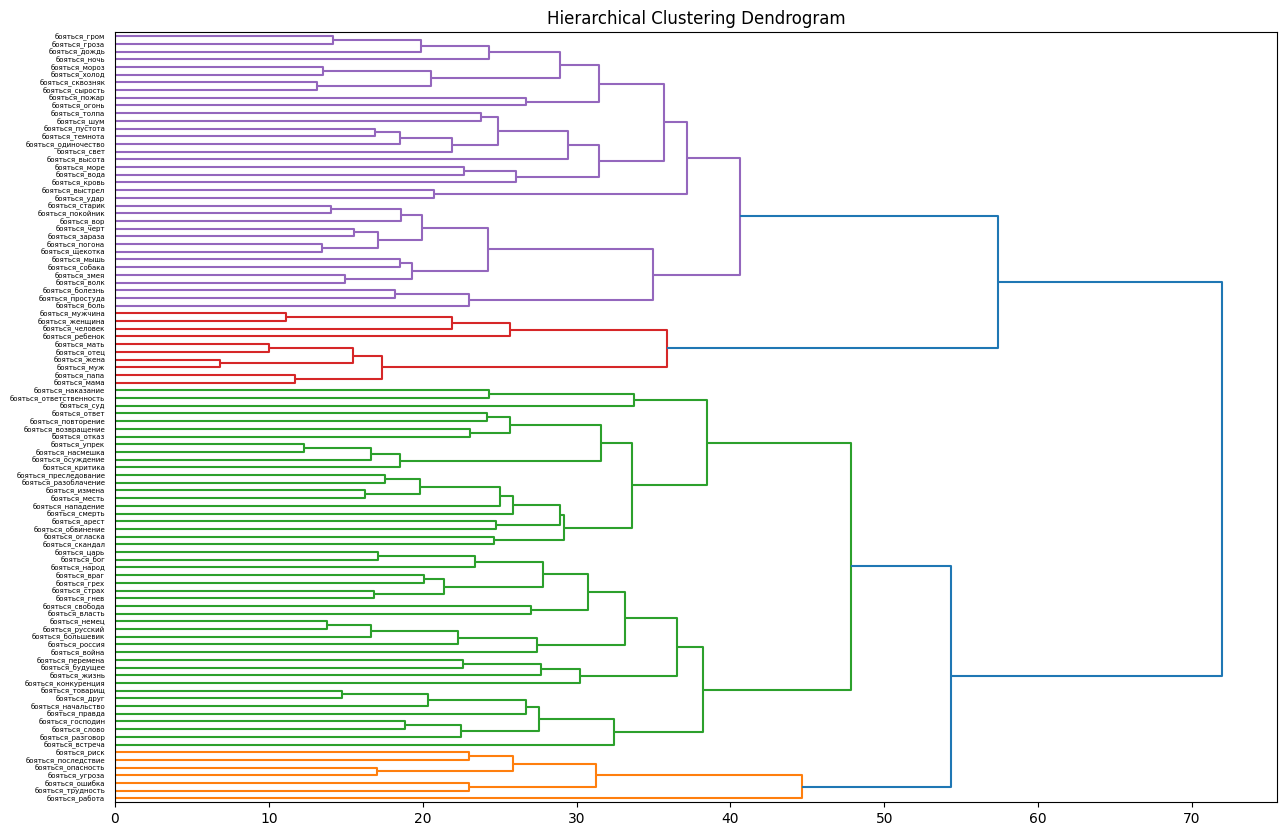

In [106]:
from scipy.cluster.hierarchy import ward, dendrogram
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as hcluster

linkage_matrix = ward(vectors_matrix)

plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, orientation="right", labels=collocations)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

In [107]:
clusters = hcluster.fcluster(linkage_matrix, 1)
print('Estimated number of clusters: %d' % len(set(clusters)))

Estimated number of clusters: 32


In [108]:
centers = {}
closest_elements = {}
for label in set(clusters):
    cluster_indices = np.where(clusters == label)[0]
    if len(cluster_indices) <= 2:
        continue
    
    cluster_vectors = [vector_representations[idx] for idx in cluster_indices]
    cluster_center = np.mean(cluster_vectors, axis=0)
    centers[label] = cluster_center
    
    similarities = cosine_similarity(cluster_vectors, [cluster_center])
    closest_indices = similarities.argsort(axis=0, kind='stable')[-3:, 0]
    closest_elements[label] = [collocations[idx] for idx in closest_indices for idx in cluster_indices]

In [109]:
# Формирование групп из трех словосочетаний
fear_groups = []
for label, center in centers.items():
    closest = closest_elements[label]
    group = [closest[i:i+3] for i in range(0, len(closest), 3)]
    fear_groups.extend(group)

for idx, group in enumerate(fear_groups, 1):
    print(f"Группа {idx}: {', '.join(group)}")

Группа 1: бояться_последствие, бояться_угроза, бояться_риск
Группа 2: бояться_опасность, бояться_последствие, бояться_угроза
Группа 3: бояться_риск, бояться_опасность, бояться_последствие
Группа 4: бояться_угроза, бояться_риск, бояться_опасность
Группа 5: бояться_слово, бояться_встреча, бояться_правда
Группа 6: бояться_господин, бояться_друг, бояться_начальство
Группа 7: бояться_товарищ, бояться_разговор, бояться_слово
Группа 8: бояться_встреча, бояться_правда, бояться_господин
Группа 9: бояться_друг, бояться_начальство, бояться_товарищ
Группа 10: бояться_разговор, бояться_слово, бояться_встреча
Группа 11: бояться_правда, бояться_господин, бояться_друг
Группа 12: бояться_начальство, бояться_товарищ, бояться_разговор
Группа 13: бояться_жизнь, бояться_конкуренция, бояться_будущее
Группа 14: бояться_перемена, бояться_жизнь, бояться_конкуренция
Группа 15: бояться_будущее, бояться_перемена, бояться_жизнь
Группа 16: бояться_конкуренция, бояться_будущее, бояться_перемена
Группа 17: бояться_во

Здесь группы получились довольно однородными. Например, существительные, обозначающие людей, относятся к одной группе. Или же существительные, обозначающие чувства и эмоции, скорее всего будут находиться в одной группе. 

## Алгоритм К-средних (KMeans)

In [32]:
import numpy as np
from sklearn.cluster import KMeans

# Автоматическое определение количества кластеров с порогом t = 5
t = 5
kmeans_auto = KMeans(n_clusters=t+1, random_state=0).fit(vectors_matrix)
clusters_auto = kmeans_auto.labels_

print("Результаты автоматической кластеризации:")
for collocation, cluster in zip(collocations, clusters_auto):
    print(f'{collocation}: Cluster {cluster}')

Результаты автоматической кластеризации:
бояться_смерть: Cluster 1
бояться_человек: Cluster 1
бояться_бог: Cluster 1
бояться_темнота: Cluster 3
бояться_вода: Cluster 3
бояться_слово: Cluster 2
бояться_ответственность: Cluster 4
бояться_встреча: Cluster 5
бояться_жизнь: Cluster 2
бояться_отец: Cluster 1
бояться_правда: Cluster 2
бояться_высота: Cluster 3
бояться_война: Cluster 2
бояться_наказание: Cluster 2
бояться_гроза: Cluster 3
бояться_одиночество: Cluster 1
бояться_холод: Cluster 3
бояться_простуда: Cluster 3
бояться_свет: Cluster 3
бояться_грех: Cluster 2
бояться_гнев: Cluster 2
бояться_собака: Cluster 1
бояться_женщина: Cluster 1
бояться_суд: Cluster 2
бояться_огонь: Cluster 3
бояться_господин: Cluster 2
бояться_народ: Cluster 2
бояться_разоблачение: Cluster 2
бояться_месть: Cluster 2
бояться_власть: Cluster 2
бояться_кровь: Cluster 3
бояться_скандал: Cluster 2
бояться_мать: Cluster 1
бояться_трудность: Cluster 4
бояться_последствие: Cluster 4
бояться_конкуренция: Cluster 2
боять

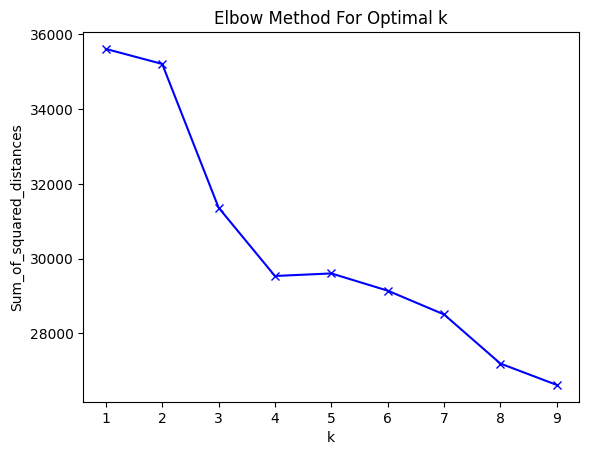

In [76]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Sum_of_squared_distances = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vectors_matrix)
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [78]:
# Ручное задание количества кластеров k = 6
k = 6
kmeans_manual = KMeans(n_clusters=k, random_state=0).fit(vectors_matrix)
clusters_manual = kmeans_manual.labels_

# Результаты ручной кластеризации
print("\nРезультаты ручной кластеризации:")
for collocation, cluster in zip(collocations, clusters_manual):
    print(f'{collocation}: Cluster {cluster}')


Результаты ручной кластеризации:
бояться_смерть: Cluster 1
бояться_человек: Cluster 1
бояться_бог: Cluster 1
бояться_темнота: Cluster 3
бояться_вода: Cluster 3
бояться_слово: Cluster 2
бояться_ответственность: Cluster 4
бояться_встреча: Cluster 5
бояться_жизнь: Cluster 2
бояться_отец: Cluster 1
бояться_правда: Cluster 2
бояться_высота: Cluster 3
бояться_война: Cluster 2
бояться_наказание: Cluster 2
бояться_гроза: Cluster 3
бояться_одиночество: Cluster 1
бояться_холод: Cluster 3
бояться_простуда: Cluster 3
бояться_свет: Cluster 3
бояться_грех: Cluster 2
бояться_гнев: Cluster 2
бояться_собака: Cluster 1
бояться_женщина: Cluster 1
бояться_суд: Cluster 2
бояться_огонь: Cluster 3
бояться_господин: Cluster 2
бояться_народ: Cluster 2
бояться_разоблачение: Cluster 2
бояться_месть: Cluster 2
бояться_власть: Cluster 2
бояться_кровь: Cluster 3
бояться_скандал: Cluster 2
бояться_мать: Cluster 1
бояться_трудность: Cluster 4
бояться_последствие: Cluster 4
бояться_конкуренция: Cluster 2
бояться_боль

In [81]:
# для кластеризации k=6
centers = {}
closest_elements = {}
for label in set(clusters_manual):
    cluster_indices = np.where(clusters_manual == label)[0]
    if len(cluster_indices) <= 2:
        continue
    
    cluster_vectors = [vector_representations[idx] for idx in cluster_indices]
    cluster_center = np.mean(cluster_vectors, axis=0)
    centers[label] = cluster_center
    
    similarities = cosine_similarity(cluster_vectors, [cluster_center])
    closest_indices = similarities.argsort(axis=0, kind='stable')[-3:, 0]
    closest_elements[label] = [collocations[idx] for idx in closest_indices for idx in cluster_indices]

In [82]:
# Формирование групп из трех словосочетаний
result_groups = []
for label, center in centers.items():
    closest = closest_elements[label]
    group = [closest[i:i+3] for i in range(0, len(closest), 3)]
    result_groups.extend(group)


for idx, group in enumerate(result_groups, 1):
    print(f"Группа {idx}: {', '.join(group)}")

Группа 1: бояться_смерть, бояться_человек, бояться_бог
Группа 2: бояться_отец, бояться_одиночество, бояться_собака
Группа 3: бояться_женщина, бояться_мать, бояться_мама
Группа 4: бояться_муж, бояться_друг, бояться_начальство
Группа 5: бояться_жена, бояться_вор, бояться_покойник
Группа 6: бояться_ребенок, бояться_волк, бояться_товарищ
Группа 7: бояться_царь, бояться_черт, бояться_старик
Группа 8: бояться_мужчина, бояться_немец, бояться_папа
Группа 9: бояться_смерть, бояться_человек, бояться_бог
Группа 10: бояться_отец, бояться_одиночество, бояться_собака
Группа 11: бояться_женщина, бояться_мать, бояться_мама
Группа 12: бояться_муж, бояться_друг, бояться_начальство
Группа 13: бояться_жена, бояться_вор, бояться_покойник
Группа 14: бояться_ребенок, бояться_волк, бояться_товарищ
Группа 15: бояться_царь, бояться_черт, бояться_старик
Группа 16: бояться_мужчина, бояться_немец, бояться_папа
Группа 17: бояться_смерть, бояться_человек, бояться_бог
Группа 18: бояться_отец, бояться_одиночество, боя

Здесь тоже существительные, обозначающие людей, находятся в одной группе. Мне кажется, что группы получилисб более менее однородными. 

In [84]:
# для автоматической кластеризации
centers = {}
closest_elements = {}
for label in set(clusters_auto):
    cluster_indices = np.where(clusters_auto == label)[0]
    if len(cluster_indices) <= 2:
        continue
    
    cluster_vectors = [vector_representations[idx] for idx in cluster_indices]
    cluster_center = np.mean(cluster_vectors, axis=0)
    centers[label] = cluster_center
    
    similarities = cosine_similarity(cluster_vectors, [cluster_center])
    closest_indices = similarities.argsort(axis=0, kind='stable')[-3:, 0]
    closest_elements[label] = [collocations[idx] for idx in closest_indices for idx in cluster_indices]

In [85]:
# Формирование групп из трех словосочетаний
result_groups = []
for label, center in centers.items():
    closest = closest_elements[label]
    group = [closest[i:i+3] for i in range(0, len(closest), 3)]
    result_groups.extend(group)


for idx, group in enumerate(result_groups, 1):
    print(f"Группа {idx}: {', '.join(group)}")

Группа 1: бояться_смерть, бояться_человек, бояться_бог
Группа 2: бояться_отец, бояться_одиночество, бояться_собака
Группа 3: бояться_женщина, бояться_мать, бояться_мама
Группа 4: бояться_муж, бояться_друг, бояться_начальство
Группа 5: бояться_жена, бояться_вор, бояться_покойник
Группа 6: бояться_ребенок, бояться_волк, бояться_товарищ
Группа 7: бояться_царь, бояться_черт, бояться_старик
Группа 8: бояться_мужчина, бояться_немец, бояться_папа
Группа 9: бояться_смерть, бояться_человек, бояться_бог
Группа 10: бояться_отец, бояться_одиночество, бояться_собака
Группа 11: бояться_женщина, бояться_мать, бояться_мама
Группа 12: бояться_муж, бояться_друг, бояться_начальство
Группа 13: бояться_жена, бояться_вор, бояться_покойник
Группа 14: бояться_ребенок, бояться_волк, бояться_товарищ
Группа 15: бояться_царь, бояться_черт, бояться_старик
Группа 16: бояться_мужчина, бояться_немец, бояться_папа
Группа 17: бояться_смерть, бояться_человек, бояться_бог
Группа 18: бояться_отец, бояться_одиночество, боя

Существительные, обозначающие людей, относятся чаще всего к одной группе. Существительные, как измена, осуждение, встречаются в одной группе